In [2]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import warnings
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.model_selection import train_test_split
init_notebook_mode(connected=True)
import pickle
import gc
from collections import Counter, defaultdict
import lightgbm as lgb
warnings.filterwarnings('ignore')
%matplotlib inline
from IPython.display import display, Image, HTML
import shap

import src.data_loader as data_loader
import src.lightbgm as lightgbm_model


In [3]:
X_train, y = data_loader.preload_credit_risk_data()


The shape of application data: (307511, 128)
The shape application and bureau data combined: (307511, 163)
(307511, 506)


In [4]:
X_train_final = X_train

X_train_final_RM = X_train_final.copy()
X_train_final_RM.columns = [f"feature_{i}" for i in range(X_train_final.shape[1])]


In [5]:
model_sk, s = lightgbm_model.train_lightgbm(X_train_final_RM, y)

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid auc: 0.756691 + 0.0021615
[200]	cv_agg's valid auc: 0.765534 + 0.00230031
[300]	cv_agg's valid auc: 0.770277 + 0.00248682
[400]	cv_agg's valid auc: 0.773879 + 0.00269239
[500]	cv_agg's valid auc: 0.776839 + 0.00290566
[600]	cv_agg's valid auc: 0.77902 + 0.00286899
[700]	cv_agg's valid auc: 0.780648 + 0.0028633
[800]	cv_agg's valid auc: 0.781825 + 0.00289735
[900]	cv_agg's valid auc: 0.782625 + 0.00295003
[1000]	cv_agg's valid auc: 0.783188 + 0.00294627
[1100]	cv_agg's valid auc: 0.78359 + 0.00298968
[1200]	cv_agg's valid auc: 0.783951 + 0.00293932
[1300]	cv_agg's valid auc: 0.784254 + 0.00290249
[1400]	cv_agg's valid auc: 0.784551 + 0.00283337
[1500]	cv_agg's valid auc: 0.78477 + 0.00283548
[1600]	cv_agg's valid auc: 0.784941 + 0.00283369
[1700]	cv_agg's valid auc: 0.785095 + 0.00282347
[1800]	cv_agg's valid auc: 0.785239 + 0.0027778
[1900]	cv_agg's valid auc: 0.785386 + 0.0027405
[2000]	cv_agg's valid a

In [7]:
OOF = s.get_oof(X_train_final.shape[0])
roc_auc_score(y, OOF)

0.7864919361276942

<Axes: title={'center': 'Histogram of predictions'}, ylabel='Frequency'>

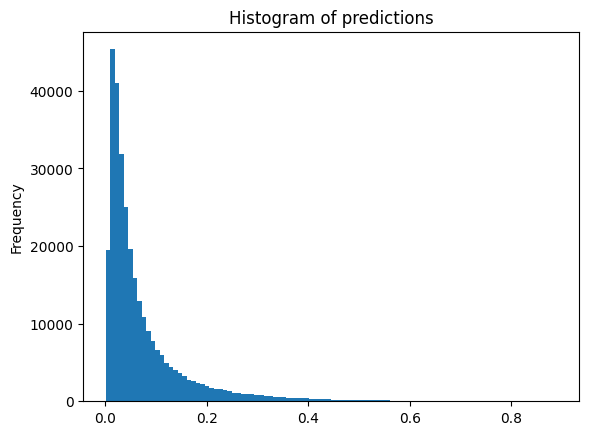

In [8]:
pd.Series(OOF).plot.hist(bins=100, title='Histogram of predictions')

<Axes: title={'center': 'Smoothed OOF prediction'}>

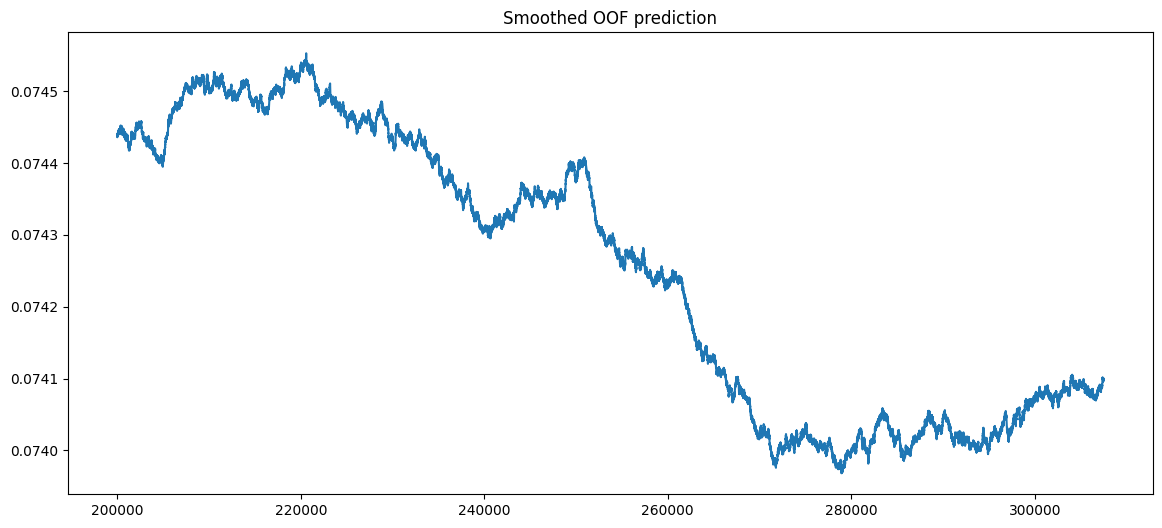

In [9]:
pd.Series(OOF).rolling(200000).mean().plot(figsize=(14,6), title='Smoothed OOF prediction')

<Axes: title={'center': 'Adversarial AUC Logs'}>

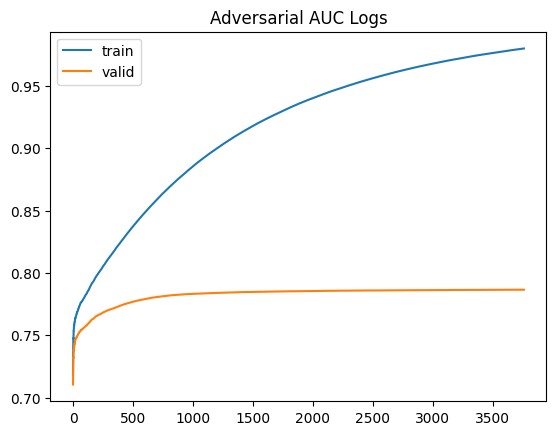

In [10]:
logs = pd.DataFrame({'train':s.train_log().mean(1), 'valid':s.valid_log().mean(1)})
logs.train.plot(legend=True, title='Adversarial AUC Logs')
logs.valid.plot(legend=True)

In [11]:
def make_importances(clf, importance_type):
    return pd.Series(data=clf.feature_importance(importance_type), index=clf.feature_name())

original_feature_names = X_train_final.columns.tolist()
feature_mapping = {f"feature_{i}": original_feature_names[i] for i in range(len(original_feature_names))}

IMPORTANCES = pd.concat([make_importances(b, 'gain') for b in s.model.boosters], axis=1).sum(axis=1).to_frame('Gain')
IMPORTANCES['Count'] = pd.concat([make_importances(b, 'split') for b in s.model.boosters], axis=1).sum(axis=1)

IMPORTANCES.index = IMPORTANCES.index.map(feature_mapping)

IMPORTANCES.sort_values('Gain', ascending=False).head()

,Gain,Count
EXT_SOURCE_2,880675.395489,14895
EXT_SOURCE_3,815801.801392,13490
CREDIT_TERM,340045.154032,18260
EXT_SOURCE_1,330282.681717,12869
DAYS_BIRTH,220793.694220,15826


<Axes: title={'center': 'Adversarial Feature Gain'}>

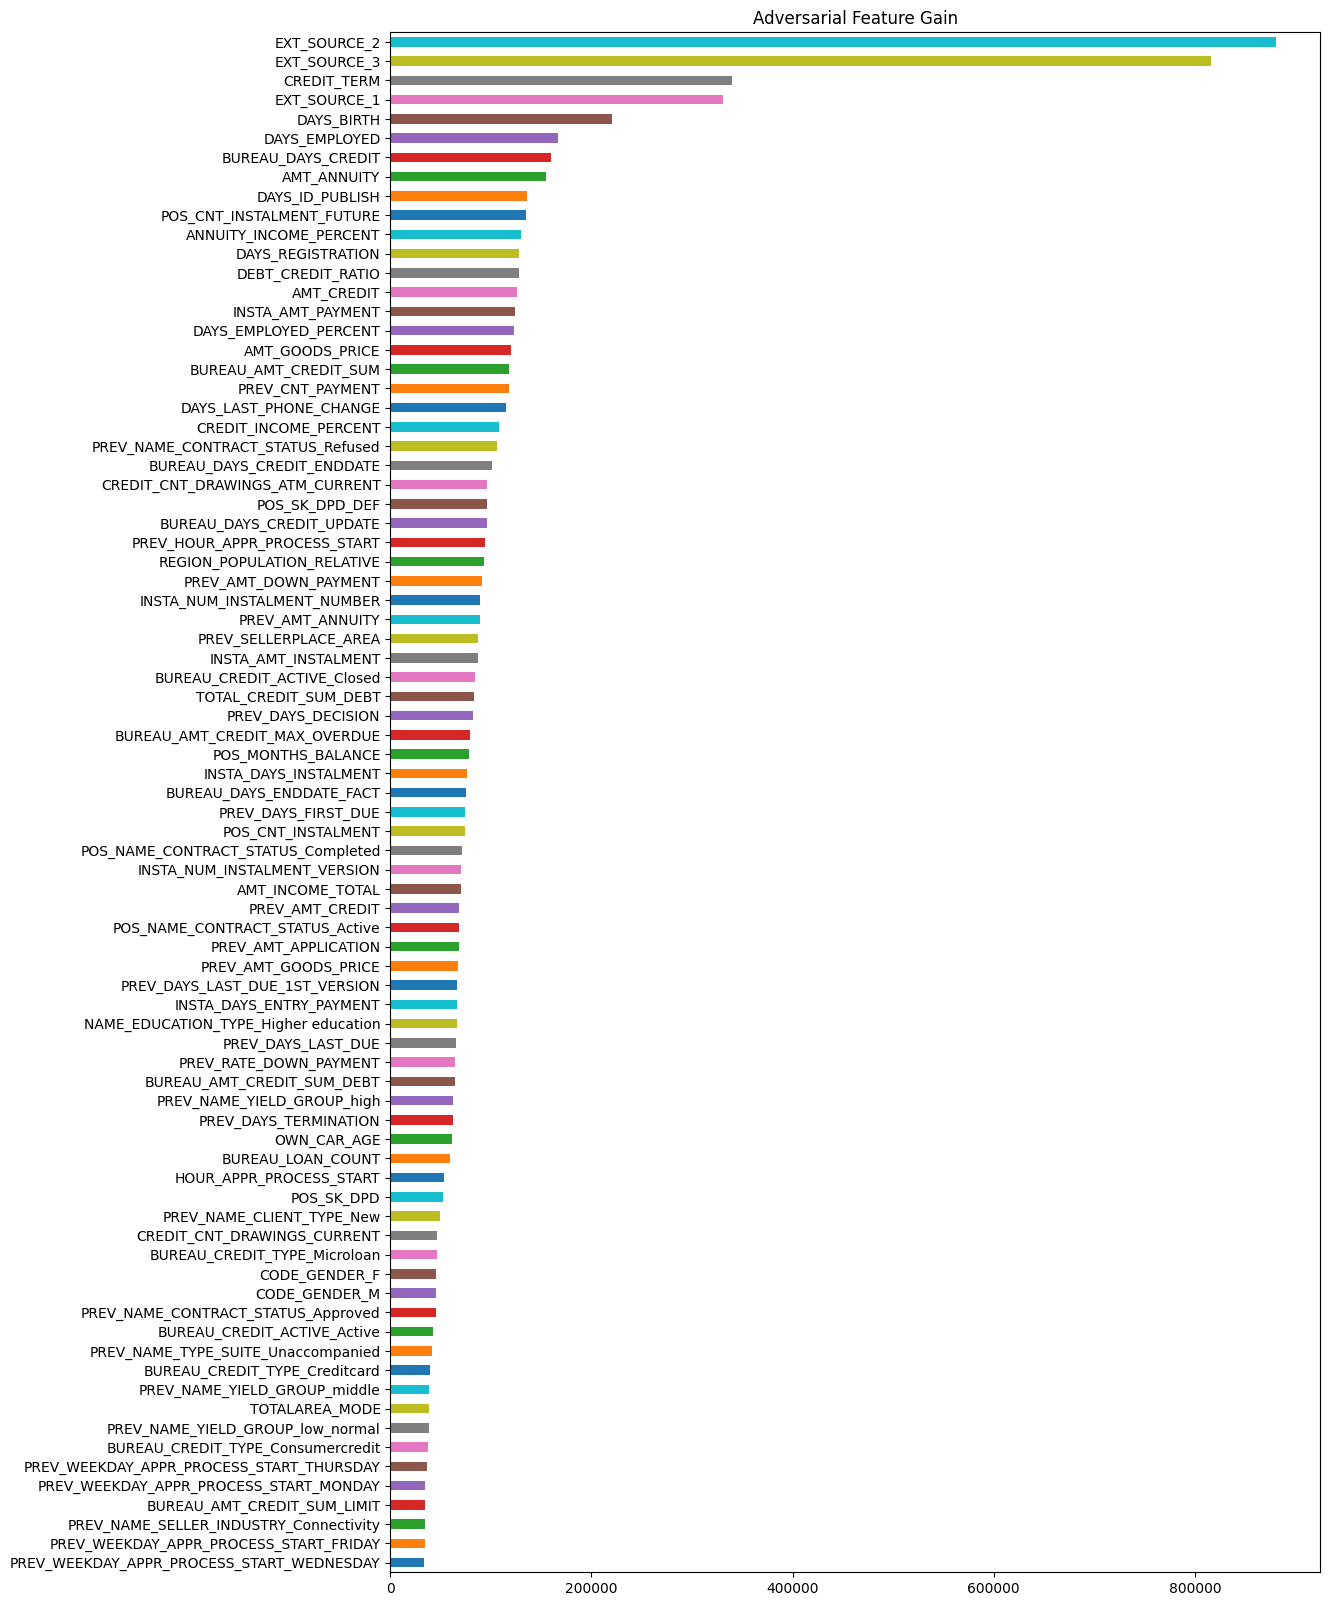

In [12]:
COLORS = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]
toplot = IMPORTANCES.sort_values('Gain').tail(80)
toplot['Gain'].plot.barh(figsize=(12,20), color=COLORS, title='Adversarial Feature Gain')

In [13]:
def get_split_point_stats_multi(clfs):
    split_points = defaultdict(Counter)

    def visit_node(d):
        if 'tree_info' in d:
            for tree in d['tree_info']: # a list of trees
                visit_node(tree)
        for k in ['tree_structure', 'left_child', 'right_child' ]:
            if k in d:
                visit_node(d[k])
        if 'split_feature' in d:
            split_points[names[d['split_feature']]] [d['threshold']] += d['split_gain']

    for clf in clfs:
        names = clf.feature_name()
        visit_node(clf.dump_model())
    return split_points

split_points = get_split_point_stats_multi(s.model.boosters)

In [14]:


MAX_SHOW = 50
ADJS = 'abundant:common:ubiquitous:omnipresent:rampant:rife:permeant:widespread:legendary:popular:fashionable:frequent:usual:useful:predominant:recurrent:repetitive:repetitious:marked:prevalent:prevalent:prevalent'.split(':')

np.random.seed(42)

def plot_it(col,feature_mapping):
    counts = split_points[col]
    col_map = feature_mapping[col]
    ser = pd.Series(dict(counts)).sort_values(ascending=False)
    total_gain = IMPORTANCES.loc[col_map, 'Gain']
    total_splits = IMPORTANCES.loc[col_map, 'Count']

    if hasattr(X_train_final[col_map], 'cat'):
        # remap categories from int -> cat value
        try:
            ser.index = X_train_final[col_map].cat.categories[ser.index.astype(int)]
        except:
            # e.g. TypeError: Cannot cast Index to dtype <class 'int'>
            # a categorical with many categories and '1||4||7' etc type splits
            # leave it as it is
            pass
    adj = np.random.choice(ADJS)
    display(
        HTML(
            f'<h1 id="plot_{col_map}">{col_map}</h1>'
            f'<p>Used {total_splits} times, total gain is {total_gain}.'
            f'<p>{len(ser)} split point values used. '
            f'Most {adj} is {ser.index[0]} with gain of {ser.values[0]}.'
        )
    )
    ser = ser.head(MAX_SHOW).sort_index()
    ax = ser.plot.bar(title=f'{col_map} — Adversarial split points by gain',
                      rot=90, fontsize=12, figsize=(15,5),
                      width=0.7, color=COLORS)
    plt.show()

In [ ]:
for col in X_train_final_RM.columns.tolist():
    counts = split_points[col]
    if len(counts) >= 2:
        plot_it(col,feature_mapping)